In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [10]:
UID_PREFIX = "1.2.826.0.1.3680043."
DATA_DIR = "/Volumes/SSD9701/"
# DATA_DIR = "/root/autodl-tmp/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

IMAGES_DIR = os.path.join(DATA_DIR, "train_sagittal_images_jpeg95")
RAW_MASK_DIR = os.path.join(DATA_DIR, "train_sagittal_labels_raw_jpeg95")
MASK_DIR = os.path.join(DATA_DIR, "train_sagittal_labels_jpeg95")


In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
train_df['UID'] = train_df['StudyInstanceUID']
train_df = train_df[["UID", "C2"]].set_index('UID')
print(len(train_df))
train_df.head()

2019


,C2
UID,
1.2.826.0.1.3680043.6200,1
1.2.826.0.1.3680043.27262,1
1.2.826.0.1.3680043.21561,1
1.2.826.0.1.3680043.12351,0
1.2.826.0.1.3680043.1363,0


In [4]:
c2_df = train_df[train_df.C2 == 1]
c2_df.head()

,C2
UID,
1.2.826.0.1.3680043.6200,1
1.2.826.0.1.3680043.27262,1
1.2.826.0.1.3680043.21561,1
1.2.826.0.1.3680043.15773,1
1.2.826.0.1.3680043.26052,1


C2 의 원하는 slice 위치를 알려준다.

In [5]:
center_df = pd.read_csv(os.path.join(DATA_DIR, 'sagittal_center_slice.csv'))
center_df = center_df.astype({'UID':'string'})
for i in range(len(center_df)):
    center_df.at[i, "UID"] = f"1.2.826.0.1.3680043.{center_df.iloc[i].UID}"
center_df = center_df.set_index('UID')
print(len(center_df))
center_df.head()

2011


,sagittal_center_slice,label_scale
UID,,
1.2.826.0.1.3680043.10001,281,32
1.2.826.0.1.3680043.10005,255,32
1.2.826.0.1.3680043.10014,261,32
1.2.826.0.1.3680043.10016,278,32
1.2.826.0.1.3680043.10032,250,32


In [6]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_sagittal_position.csv'))
boundary_df = boundary_df.drop_duplicates(subset='UID').set_index('UID')
print(len(boundary_df))
boundary_df = boundary_df[['left','top','right','bottom']]
boundary_df.head()

2012


,left,top,right,bottom
UID,,,,
1.2.826.0.1.3680043.10001,49,98,377,590
1.2.826.0.1.3680043.10005,22,0,366,291
1.2.826.0.1.3680043.10014,28,148,480,882
1.2.826.0.1.3680043.10016,37,98,396,601
1.2.826.0.1.3680043.10032,28,125,413,584


In [7]:
train_df = train_df.loc[center_df.index]
boundary_df = boundary_df.loc[center_df.index]
print(len(train_df), len(boundary_df))

2011 2011


In [8]:
df = pd.concat((train_df, center_df, boundary_df), axis=1)
print(len(df))
df.head()

2011


,C2,sagittal_center_slice,label_scale,left,top,right,bottom
UID,,,,,,,
1.2.826.0.1.3680043.10001,0,281,32,49,98,377,590
1.2.826.0.1.3680043.10005,0,255,32,22,0,366,291
1.2.826.0.1.3680043.10014,0,261,32,28,148,480,882
1.2.826.0.1.3680043.10016,1,278,32,37,98,396,601
1.2.826.0.1.3680043.10032,0,250,32,28,125,413,584


In [28]:
df.to_csv('meta_sagittal_c2_center.csv')

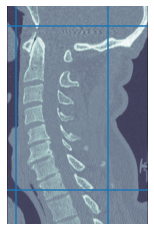

In [27]:
s = df.iloc[1000]

plt.imshow(Image.open(os.path.join(IMAGES_DIR,s.name, f"{s.sagittal_center_slice}.jpeg")), cmap='bone')
plt.axis('off')
plt.axvline(s.left)
plt.axvline(s.right)
plt.axhline(s.top)
plt.axhline(s.bottom)